# Import libraries

In [2]:
import pathlib
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
# from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

# Read data from file

In [3]:
path = pathlib.Path('D:\DataScience\Real-Time-Data-Analysis\data\\raw\data.csv')

df = pd.read_csv(path,index_col='index',parse_dates=True)

# Looking into data

In [4]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume,Date
index,,,,,,,
2022-12-01 11:15:00,18840.300781,18842.300781,18817.650391,18834.550781,18834.550781,0,NaN
2022-12-01 12:15:00,18833.949219,18855.699219,18832.449219,18844.150391,18844.150391,0,NaN
2022-12-01 13:15:00,18844.150391,18853.099609,18778.500000,18824.449219,18824.449219,0,NaN
2022-12-01 14:15:00,18823.599609,18845.300781,18795.949219,18808.150391,18808.150391,0,NaN
2022-12-01 15:15:00,18808.400391,18820.599609,18799.550781,18800.949219,18800.949219,0,NaN


In [5]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume,Date
count,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.0,0.0
mean,17143.411609,17177.410192,17106.714773,17142.955283,17142.955283,0.0,NaN
std,756.356749,750.632969,760.269655,756.406187,756.406187,0.0,NaN
min,15263.950195,15324.750000,15185.549805,15265.299805,15265.299805,0.0,NaN
25%,16600.900391,16639.250000,16566.949219,16609.800781,16609.800781,0.0,NaN
50%,17254.900391,17287.949219,17220.199219,17254.900391,17254.900391,0.0,NaN
75%,17667.650391,17695.000000,17635.750000,17661.099609,17661.099609,0.0,NaN
max,18871.949219,18886.699219,18832.449219,18844.150391,18844.150391,0.0,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1737 entries, 2021-12-02 09:15:00 to 2022-12-01 15:15:00
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1737 non-null   float64
 1   High       1737 non-null   float64
 2   Low        1737 non-null   float64
 3   Close      1737 non-null   float64
 4   Adj Close  1737 non-null   float64
 5   Volume     1737 non-null   int64  
 6   Date       0 non-null      float64
dtypes: float64(6), int64(1)
memory usage: 108.6 KB


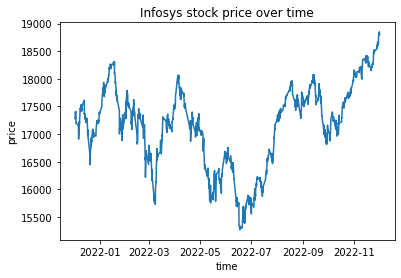

In [7]:
plt.plot(df.index, df["Close"])
plt.title("Infosys stock price over time")
plt.xlabel("time")
plt.ylabel("price")
plt.show()

# Find p, d, and q values for ARIMA model 

Before building the ARIMA model, let’s see if there is some cross-correlation in out data.

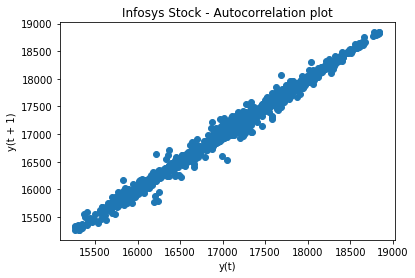

In [8]:
lag_plot(df['Close'], lag=1)
plt.title('Infosys Stock - Autocorrelation plot')
plt.show()

p is order of Autoregrassion <br>
d is order of differencing requiredd to make time series stationary <br>
q is order Moving aaverages

## Stationarity

Substract current value from previous value. We need to do diffenting peration multiple times to make series stationary. <br>
Select minimun value for ARIMA model.

### ADF test

We will use Augumented Dickey Fuller (ADF) test check stationarity in series. <br>
<br>
Null hypothesis of ADF test is that time series is non-stationary. If p-value of test is less than 0.05 then wee can reject null hypothesis. <br>
So, if p-value > 0.05 we'll find order of diffencing.  

In [9]:
from statsmodels.tsa.stattools import adfuller

In [10]:
dftest = adfuller(df['Close'],autolag='AIC')
print('1. ADF statistic :',dftest[0])
print('2. P-value :',dftest[1])

1. ADF statistic : -1.3395058532992503
2. P-value : 0.6109102264480233


## ## We find our series is non-stationary.

In [11]:
# from pmdarima import auto_arima
# import warnings
# warnings.filterwarnings('ignore')

## Autocorrelation Function (ACF) Plot

In [12]:
from statsmodels.graphics.tsaplots import plot_acf

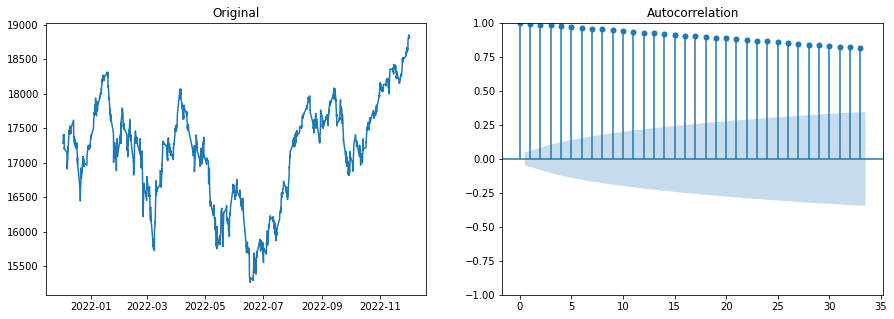

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(df['Close'])
ax1.set_title('Original')
plot_acf(df['Close'], ax=ax2);

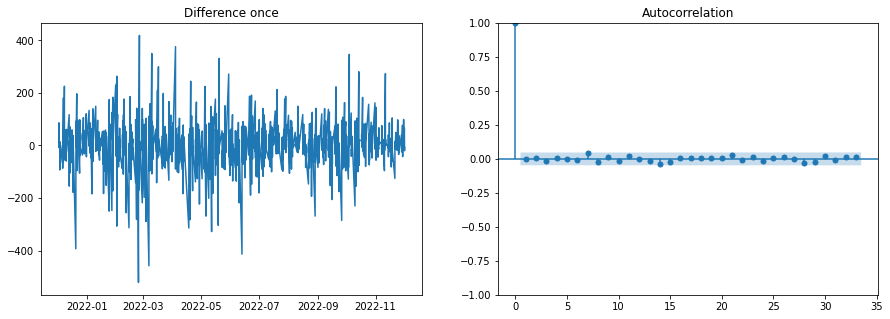

In [14]:
diff = df['Close'].diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(diff)
ax1.set_title('Difference once')
plot_acf(diff, ax=ax2);

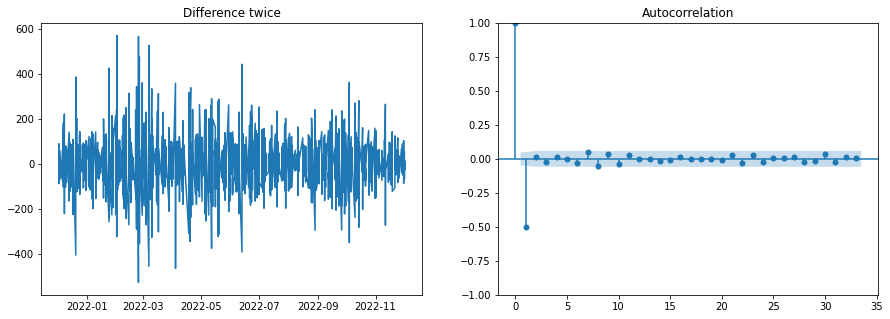

In [15]:
diff = df['Close'].diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(diff)
ax1.set_title('Difference twice')
plot_acf(diff, ax=ax2);

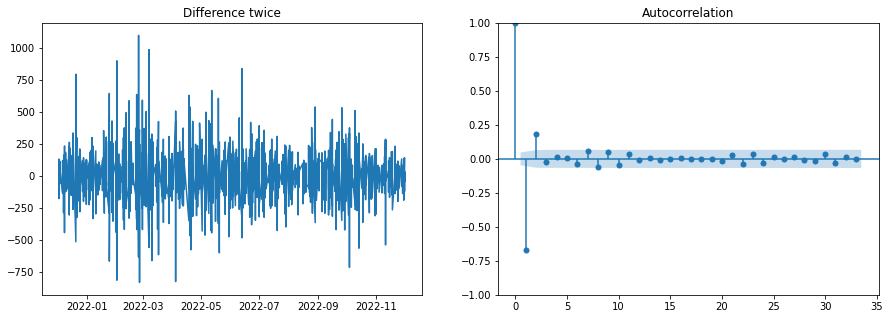

In [16]:
diff = df['Close'].diff().diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(diff)
ax1.set_title('Difference twice')
plot_acf(diff, ax=ax2);

## ## Here we find diffence order 3 is good.

Because there is gives positive value in third order differencing.

# p

p is the order of Auto regression (AR). It refers to number of lags to be used ass predictors. <br>
We can find required number of AR terms by inspecting Partial Autocorrelation (PACF) plot. <br>
The Partial Autocorrelation represents correlation between series and it's lags.

In [17]:
from statsmodels.graphics.tsaplots import plot_pacf

c:\Users\walde\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


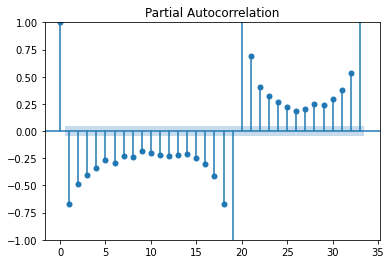

In [18]:
diff = df['Close'].diff().diff().diff().dropna()

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# ax1.plot(diff)
# ax1.set_title('Difference once')
p = plot_pacf(diff);

In [19]:
# statsmodels.tsa.stattools.pacf
from statsmodels.tsa.stattools import pacf
diff = df['Close'].diff().diff().diff().dropna()
print(pacf(diff))

[ 1.         -0.67268104 -0.48804553 -0.40264179 -0.3425966  -0.26707769
 -0.29330341 -0.2257629  -0.23656084 -0.18625447 -0.20355548 -0.21789201
 -0.22805814 -0.21676271 -0.21512844 -0.24432412 -0.30633172 -0.41364316
 -0.66991335 -1.91167683  2.11701598  0.69354752  0.40723441  0.32370392
  0.26780687  0.22384076  0.1856896   0.20508749  0.25039071  0.24262925
  0.29513164  0.37394221  0.53357904]


In [20]:
from statsmodels.tsa.stattools import acf
diff = df['Close'].diff().diff().diff().dropna()
print(acf(diff))

[ 1.00000000e+00 -6.72293101e-01  1.85081020e-01 -2.50725731e-02
  1.60475152e-02  6.00205882e-03 -3.66837795e-02  6.09931655e-02
 -6.20652748e-02  5.25681032e-02 -4.79412972e-02  3.38535578e-02
 -9.69455212e-03  3.54294311e-03 -7.04916392e-03 -3.56525402e-03
  9.75508726e-03 -3.78248088e-03  2.19021578e-03  2.19595809e-04
 -1.46890022e-02  3.15371489e-02 -3.73439154e-02  3.57651410e-02
 -2.89732101e-02  1.21698856e-02 -1.66156133e-03  1.12538654e-02
 -1.05122930e-02 -1.80094262e-02  3.87616049e-02 -3.22767327e-02
  1.43169543e-02]


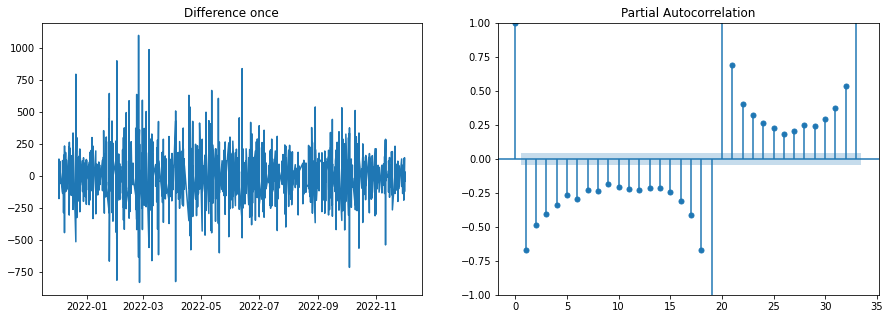

In [21]:
diff = df['Close'].diff().diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(diff)
ax1.set_title('Difference once')
plot_pacf(diff, ax=ax2);

## ## 20 is the positive value for Auto regression

# q

q is the order of moving average (MA). It refers to number of laged forecast erros that should be go into the ARIMA. <br>
We can look at ACF plot for number of MA term.

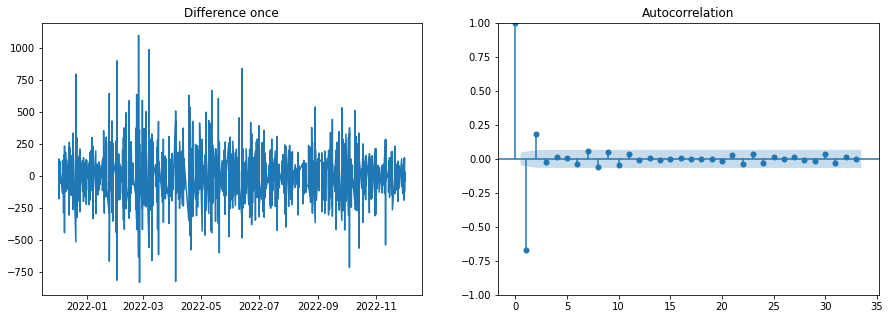

In [22]:
diff = df['Close'].diff().diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(diff)
ax1.set_title('Difference once')
plot_acf(diff, ax=ax2);

## ## We find that 2 is no order for MA

In [23]:
# stepswise_fit = auto_arima(df['Close'], trace=True, suppress_warnings=True)
# stepswise_fit.summary()

# Let's build model

In [24]:
# train_data, test_data = df[0:int(len(df)*0.9)], df[int(len(df)*0.9):]

# training_data = train_data['Close'].values
# test_data = test_data['Close'].values

# history = [x for x in training_data]
# model_predictions = []
# N_test_observations = len(test_data)

# residuals = 0

# for time_point in range(N_test_observations):
#     model = ARIMA(history, order=(20,3,2))
#     model_fit = model.fit()
#     output = model_fit.forecast()
#     yhat = output[0]
#     model_predictions.append(yhat)
#     true_test_value = test_data[time_point]
#     history.append(true_test_value)

#     residuals = pd.DataFrame(model_fit.resid)
    
# MSE_error = mean_squared_error(test_data, model_predictions)
# print('Testing Mean Squared Error is {}'.format(MSE_error))

In [25]:
# residuals = residuals[1:]

In [26]:
# fig, ax = plt.subplots(1,2)
# residuals.plot(title="Residuals", ax=ax[0])
# residuals.plot(kind='kde', title='Density', ax=ax[1])
# plt.show()

In [27]:
# test_set_range = df[int(len(df)*0.7):]
# plt.plot(test_set_range.index, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
# plt.plot(test_set_range.index, test_data, color='red', label='Actual Price')
# plt.title('Infosys Prices Prediction')
# plt.xlabel('Date')
# plt.ylabel('Prices')
# plt.legend()
# plt.show()

In [28]:
df.tail(10)

,Open,High,Low,Close,Adj Close,Volume,Date
index,,,,,,,
2022-11-30 13:15:00,18670.199219,18675.699219,18652.949219,18666.099609,18666.099609,0,NaN
2022-11-30 14:15:00,18665.849609,18765.699219,18660.550781,18765.199219,18765.199219,0,NaN
2022-11-30 15:15:00,18766.150391,18810.949219,18765.000000,18776.949219,18776.949219,0,NaN
2022-12-01 09:15:00,18871.949219,18886.699219,18829.949219,18843.000000,18843.000000,0,NaN
2022-12-01 10:15:00,18843.550781,18845.949219,18817.449219,18840.300781,18840.300781,0,NaN
2022-12-01 11:15:00,18840.300781,18842.300781,18817.650391,18834.550781,18834.550781,0,NaN
2022-12-01 12:15:00,18833.949219,18855.699219,18832.449219,18844.150391,18844.150391,0,NaN
2022-12-01 13:15:00,18844.150391,18853.099609,18778.500000,18824.449219,18824.449219,0,NaN
2022-12-01 14:15:00,18823.599609,18845.300781,18795.949219,18808.150391,18808.150391,0,NaN


In [29]:
history = [x for x in df['Close'].values]

modelF = ARIMA(history, order=(20,3,2))
model_Fit = modelF.fit()

c:\Users\walde\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\walde\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [37]:
future_index = pd.date_range(start='2022-11-18 09:30:00', end='2022-11-19 03:30:00', freq='1H')

In [38]:
future_index[:10]

DatetimeIndex(['2022-11-18 09:30:00', '2022-11-18 10:30:00',
               '2022-11-18 11:30:00', '2022-11-18 12:30:00',
               '2022-11-18 13:30:00', '2022-11-18 14:30:00',
               '2022-11-18 15:30:00', '2022-11-18 16:30:00',
               '2022-11-18 17:30:00', '2022-11-18 18:30:00'],
              dtype='datetime64[ns]', freq='H')

In [39]:
print(len(future_index))

19


In [40]:
output = model_Fit.forecast(steps=19)

In [41]:
output

array([18813.14425336, 18816.09897146, 18825.10331218, 18831.37325959,
       18837.98804514, 18845.32026035, 18853.97706566, 18863.14241075,
       18874.93997997, 18887.73098378, 18900.39006926, 18914.4927854 ,
       18924.22070819, 18932.66560718, 18937.25209744, 18941.47688368,
       18946.93550801, 18951.57047396, 18958.19156164])

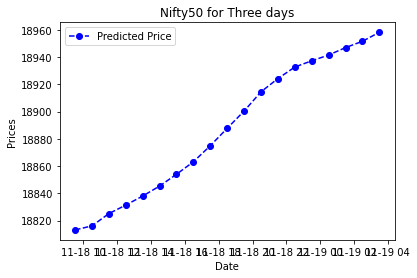

In [42]:
plt.plot(future_index, output, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.title('Nifty50 for Three days')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()

1,2,1 and 0,1,0